#Introduction

This notebook analyzes cleaned data in order to understand the relationship between temperature and kelp growth in the Salish Sea

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## def Import Data

In similar fashion to our cleaning lets load the cleaned data for each bed so we can look into their correlations and prep our temperature values for other analysis. 

In [2]:
bed_vars= [
    'Aiston_Preserve','Biz_Point','Cherry_Point_Gulf_Rd','Clallam_Bay','Coffin_Rocks',
    'Ebeys_Landing','Freshwater_Bay_1','Freshwater_Bay_2','Hat_Island','Hoypus_Point',
    'Lowell','Lummi_SW','North_Beach_East','Polnell_Point','Possession_Point',
    'Shannon_Point_East','Shannon_Point_West'
]

path = "https://raw.githubusercontent.com/sgolden3/Data-5100-Kelp/refs/heads/main/Data/cleaned_data/"

In [3]:
def dataimport(bed_vars, path):


    for var in bed_vars:
        globals()[var] = pd.read_csv(path + var + ".csv")

        

In [4]:
dataimport(bed_vars, path) 

In [5]:
Ebeys_Landing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Bed Name             27 non-null     object 
 1   Site Code            27 non-null     object 
 2   Survey Date          27 non-null     object 
 3   Survey Day           27 non-null     float64
 4   NWSC Max Ext         27 non-null     float64
 5   Survey Month         27 non-null     float64
 6   Survey Year          27 non-null     float64
 7   Acres                27 non-null     float64
 8   Temp                 18 non-null     float64
 9   Temp1 Shore Edge     9 non-null      float64
 10  Temp1 Water Edge     11 non-null     float64
 11  Temp2 Shore Edge     3 non-null      float64
 12  Temp2 Water Edge     4 non-null      float64
 13  Ave Temp Shore Edge  9 non-null      float64
 14  Ave Temp Water Edge  9 non-null      float64
dtypes: float64(12), object(3)
memory usage: 3.

## Make one consolidated temperature column

## def prepare_temp_max_extent

### Reason for? 

The current temperature column has many nans, however there are other temperature related columns (such as Temp Shore Edge) that have infomation in the same row. We want fill one singular value for temperature, based on the information we have.

Throughout the survey's history, collection protocol has become more grainular.

- 2016 - 2020: 1 Temperature Taken During Every Survey; df["Temp"]
- 2020 - 2022: 2 Temperature Taken During Every Survey; df["Ave Temp Shore Edge", "Ave Temp Water Edge"]
    - Important to know, these are not averages, they are recoded as such to reduce the size of the data files. 
- 2022 - 2024: 4 Temperature Taken During Every Survey; df["Temp1 Shore Edge",	Temp1 Water Edge",	"Temp2 Shore Edge",	"Temp2 Water Edge"]

We need to simplify all of these temperatures into singular values in order to do future analysis. 

### Logic/Algorithm Goal for First Portion of Funciton

 1. If Temp exists → use Temp
    
    2. Else:
       
        a. If both Ave Temp Shore Edge and Ave Temp Water Edge exist:
       
              (Ave Temp Shore Edge + Ave Temp Water Edge) / 2
       
        b. Else:
       
              ((Temp1 Shore Edge + Temp2 Shore Edge)/2  +
               (Temp1 Water Edge + Temp2 Water Edge)/2) / 2

Next lets do some houskeeping that we missed during our cleaning steps. 

    Date Time Object adjustment for pd.dateoffset

    Simplify datasets to NWSC Max Ext = 1 
    
        It is important that we make sure we sort Site Codes, Survey Year, & Acres. 
        
            Site Code is most important for the All_Beds analysis 
            Survey Years and Acres allow for us to drop duplicates, when Acres is ascending we can keep the larger bed. 

    Next we create PctAcreChange in order to give us an idea of what temperature catagor could be "driving" acreage change. 

    Finally, lets make a column to refer to as the t = 0 column; df[Temp_t]


In [6]:
def prepare_temp_max_extent(df):
  
    df["Temp_Final"] = np.where(
        ~df["Temp"].isna(),
        df["Temp"],
        np.where(
            (~df["Ave Temp Shore Edge"].isna()) &
            (~df["Ave Temp Water Edge"].isna()),
            (df["Ave Temp Shore Edge"] + df["Ave Temp Water Edge"]) / 2,
            (
                ((df["Temp1 Shore Edge"] + df["Temp2 Shore Edge"]) / 2) +
                ((df["Temp1 Water Edge"] + df["Temp2 Water Edge"]) / 2)
            ) / 2
        )
    )

    
    df["Survey Date"] = pd.to_datetime(df["Survey Date"])


    
    df_max = (
        df[df["NWSC Max Ext"] == 1]
        .sort_values(["Site Code", "Survey Year", "Acres"],
                     ascending=[True, True, False])
        .drop_duplicates(subset=["Site Code", "Survey Year"], keep="first")
        .copy()
    )


    
    df_max["PctAcreChange"] = (
        df_max.groupby("Site Code")["Acres"]
              .pct_change()
              * 100
    )

    

    df_max["Temp_t"] = df_max["Temp_Final"]

    return df_max

### A note about NWSC Max Ext = 1

This is a bianary tag within our raw dataset that flags the observation that was reported by Northwest Straits Commission (NWSC) to sister entities, like WA Department Natural Resources, Other Marine Resource Committies, etc. 

The explicit goal of this project is to survey the "Maximum Extent of Growth Each Season" for a given kelp forest or site. We will continue our analysis from here only on observations that are tagged with NWS Max Ext = 1. 

This is almost always August surveys, however, when weather or other complications keeps a survey in August from happening, NWSC reports the next largest survey (usually July or September survey). 

## Creating Temperature Lag Columns: def add_offset_temperatures

Here we use pd.DateOffset to create new columns based on Temp_Final, we will make 4 years worth of lagged temp data. 

We also need to create an imputation method for lagged temperatures that cannot be created during the early years of our data. 

    This imputation is done by taking the average of the temperatures for months present in the NWS Max Ext = 1 data sets. 
    
    Then using those Monthly Averages, to impute NaN values for lagged temperatures that are missing. 
    
    We match the NWS survey month, so it NWSC Max is in August, we use the average for August to fill its previous year temps, if it is in July, then we use the average for July. 

In [7]:
def add_offset_temperatures(df_max):
   

    def get_temp_for_date_and_site(target_date, site_code_to_match, df_filtered_for_temp):
        match = df_filtered_for_temp[
            (df_filtered_for_temp['Site Code'] == site_code_to_match) &
            (df_filtered_for_temp['Survey Date'].dt.year == target_date.year)
        ]
        if not match.empty:
            return match['Temp_Final'].iloc[0]
        return pd.NA

    
    def get_historical_temperatures(row, df_search):
        current_date = row['Survey Date']
        current_site_code = row['Site Code']

        if pd.isna(current_date):
            return pd.Series({
                "Temp_t_minus1": pd.NA,
                "Temp_t_minus2": pd.NA,
                "Temp_t_minus3": pd.NA,
                "Temp_t_minus4": pd.NA,
            })

        one_year_ago    = current_date - pd.DateOffset(years=1)
        two_years_ago   = current_date - pd.DateOffset(years=2)
        three_years_ago = current_date - pd.DateOffset(years=3)
        four_years_ago  = current_date - pd.DateOffset(years=4)

        temp_1 = get_temp_for_date_and_site(one_year_ago,    current_site_code, df_search)
        temp_2 = get_temp_for_date_and_site(two_years_ago,   current_site_code, df_search)
        temp_3 = get_temp_for_date_and_site(three_years_ago, current_site_code, df_search)
        temp_4 = get_temp_for_date_and_site(four_years_ago,  current_site_code, df_search)

        return pd.Series(
            {
                "Temp_t_minus1": temp_1,
                "Temp_t_minus2": temp_2,
                "Temp_t_minus3": temp_3,
                "Temp_t_minus4": temp_4,
            }
        )


    
    df_max[
        ["Temp_t_minus1",
         "Temp_t_minus2",
         "Temp_t_minus3",
         "Temp_t_minus4"]
    ] = df_max.apply(get_historical_temperatures, axis=1, args=(df_max,))


    
    temp_cols = [
        "Temp_t",
        "Temp_t_minus1",
        "Temp_t_minus2",
        "Temp_t_minus3",
        "Temp_t_minus4"
    ]
    

    monthly_avgs = (
        df_max.groupby(["Site Code", "Survey Month"])["Temp_Final"]
              .mean()
              .rename("MonthlyTempMean")
    )
    

    df_max = df_max.merge(monthly_avgs, on=["Site Code", "Survey Month"], how="left")
    

    for col in temp_cols:
        df_max[col] = df_max[col].fillna(df_max["MonthlyTempMean"])
        

    return df_max

## Make correlation matrices for each bed

This correlation matrix creation tracks with most previous examples seen in the course. However, there are two new additions. 

    1. We want to make sure we can QA/QC the data that comes out of our pipeline. 
    
        With this being the last step we can define a select amount of columns that matter most for us using df_selected = df_max[selected_cols]. 

        Then we save and return those columns as a csv and dataframe respectively. 


    2. We also want to be able to see the overall data and their correlations, so we we will plot not just a heatmap but a pairplot ontop of the correlation, defining our correlation values to sit in the upper left of each entry in the heatmap. 

In [8]:
def corr_pairplot_and_heatmap(df_max, title=None):

 
    predictor_variables = [
        "Temp_t",
        "Temp_t_minus1",
        "Temp_t_minus2",
        "Temp_t_minus3",
        "Temp_t_minus4"
    ]


    numerical_predictors = (
        df_max[predictor_variables]
        .select_dtypes(include="number")
        .columns
        .to_list()
    )


    corr_matrix = df_max[numerical_predictors + ["Acres", "PctAcreChange"]].corr()


    selected_cols = [
        "Bed Name", "Site Code", "Survey Day", "Survey Month", "Survey Year",
        "Acres",
        "Temp_t",
        "Temp_t_minus1",
        "Temp_t_minus2",
        "Temp_t_minus3",
        "Temp_t_minus4",
        "PctAcreChange",
    ]

    df_selected = df_max[selected_cols]

    g = sns.pairplot(
        data=df_selected,
        vars=numerical_predictors + ["Acres", "PctAcreChange"],
        kind="reg",
        plot_kws={"scatter_kws": {"alpha": 0.5, "color": "k", "s": 7}},
    )

    cmap = plt.get_cmap("gist_earth")


    norm = plt.Normalize(vmin=-1, vmax=1)

    for i, row_var in enumerate(corr_matrix.columns):
        for j, col_var in enumerate(corr_matrix.columns):
            ax = g.axes[i, j]
            if ax is not None:
                r = corr_matrix.loc[row_var, col_var]
                color = cmap(norm(r))
                ax.set_facecolor(color)

    for i, row_var in enumerate(corr_matrix.columns):
        for j, col_var in enumerate(corr_matrix.columns):

            ax = g.axes[i, j]
            if ax is not None:

                r = corr_matrix.loc[row_var, col_var]
                txt = f"{r:.2f}"

                ax.text(
                    0.05, 0.95, txt,
                    transform=ax.transAxes,
                    fontsize=10,
                    ha="left", va="top",
                    color="white", fontweight="bold",
                    bbox=dict(boxstyle="round,pad=0.2",
                              facecolor="black", alpha=0.3)
                )

    for ax in g.axes.flat:
        ax.set_xlabel(ax.get_xlabel(), fontsize=14, rotation=30, ha='right')
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    plt.suptitle("All Beds Pairplot & Correlation Heatmap", y=1.02, fontsize=20, fontweight='bold')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    g.fig.colorbar(sm, ax=g.axes, shrink=0.6, label="Correlation")

    plt.show()

    bed = df_max["Bed Name"].iloc[0]

    df_selected.to_csv(
        f"/Users/carterwebb/Desktop/kelps/data/cleaned_data/corr_dfs/{bed}_corrDF.csv",
        index=False
    )

    return df_selected

## The Pipeline 

prepare_temp_max_extent

    Consolidates Temp Columns by taking averages when neccesary (Especially in years 2020 - 2024) 

    Ensure Survey Date is an datetime object 

    Selects only NWSC Max Ext = 1, the previously reported dates in this project. 

    Creates PctAcreChange and Temp_T columns for analysis 


add_offset_temperatures

    Creates lag temperature columns using pd.DateOffset

    Creates and Imputes Monthly Averages where lag temperatures cannot be calculated (ie, no data before 2016). 


corr_pairplot_and_heatmap

    Creates predictor variables Temp_T through Temp_offset_minus4

    Creates Correlation Matrix

    Plots Pairplot & Correlation Matrix using methods learned in EDU Project to create Pairplot/Heatmap

    Prints a Data Frame of all observations/surveys/temperatures used in the creation of Pairplot/Heatmap for QA/QC


In [9]:
def max_corr_pipeline(df, title=None):
   
    df_max = prepare_temp_max_extent(df)
    df_max = add_offset_temperatures(df_max)

    df_selected = corr_pairplot_and_heatmap(df_max, title=title)
    return df_selected

In [10]:
    'Aiston_Preserve','Biz_Point','Cherry_Point_Gulf_Rd','Clallam_Bay','Coffin_Rocks',
    'Ebeys_Landing','Freshwater_Bay_1','Freshwater_Bay_2','Hat_Island','Hoypus_Point',
    'Lowell','Lummi_SW','North_Beach_East','Polnell_Point','Possession_Point',
    'Shannon_Point_East','Shannon_Point_West'

('Shannon_Point_East', 'Shannon_Point_West')

/var/folders/7s/t5l3pg4j2j54njys9zrdzdxr0000gn/T/ipykernel_76466/3202075690.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_max[col] = df_max[col].fillna(df_max["MonthlyTempMean"])


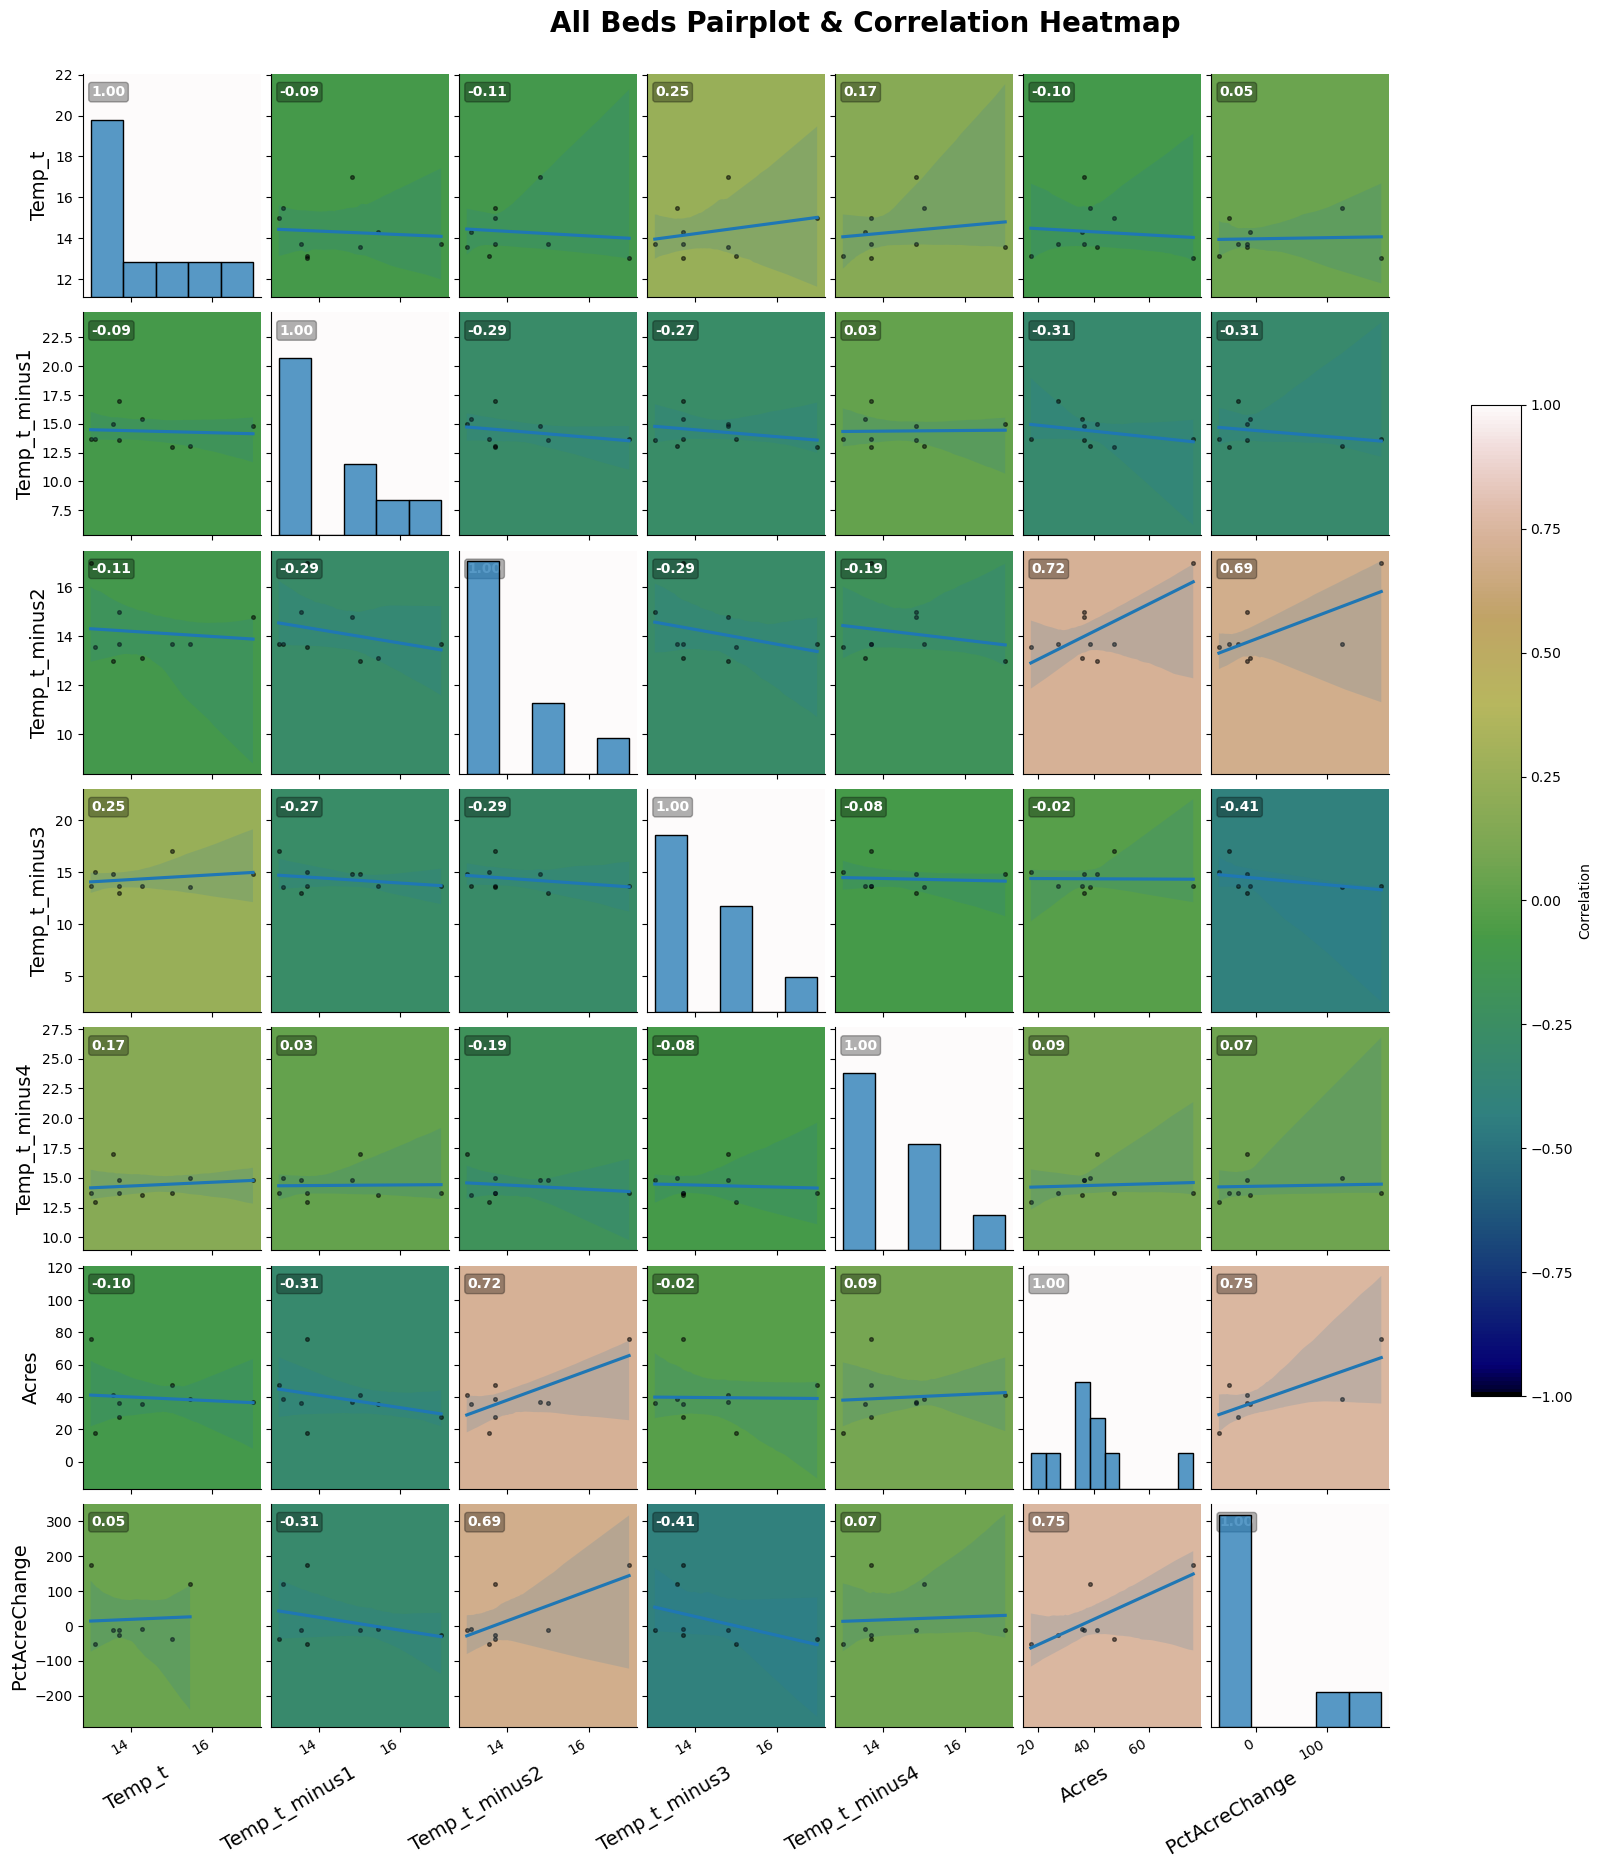

,Bed Name,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
0,Polnell Point,POLN,30.0,8.0,2016.0,36.728040,17.000,14.795,14.795,14.795,14.795,NaN
1,Polnell Point,POLN,18.0,9.0,2017.0,27.432119,13.700,17.000,13.700,13.700,13.700,-25.310147
2,Polnell Point,POLN,10.0,9.0,2018.0,75.709687,13.000,13.700,17.000,13.700,13.700,175.989204
3,Polnell Point,POLN,26.0,9.0,2019.0,47.312350,15.000,13.000,13.700,17.000,13.700,-37.508195
4,Polnell Point,POLN,31.0,8.0,2020.0,41.303716,13.550,15.000,13.000,14.795,17.000,-12.699927
5,Polnell Point,POLN,24.0,8.0,2021.0,36.426616,13.700,13.550,15.000,13.000,14.795,-11.807897
6,Polnell Point,POLN,11.0,9.0,2022.0,17.561865,13.100,13.700,13.550,15.000,13.000,-51.788371
7,Polnell Point,POLN,15.0,8.0,2023.0,38.712918,15.450,13.100,13.700,13.550,15.000,120.437399
8,Polnell Point,POLN,21.0,8.0,2024.0,35.730997,14.275,15.450,13.100,13.700,13.550,-7.702650


In [11]:
max_corr_pipeline(Polnell_Point)

In [12]:
max_corr_pipeline(Lumi_SW)

NameError: name 'Lumi_SW' is not defined

In [14]:
allbed = pd.read_csv("https://raw.githubusercontent.com/sgolden3/Data-5100-Kelp/refs/heads/main/Data/cleaned_data/AllBeds_Clean.csv")

allbed[["Temp1 Shore Edge","Temp2 Shore Edge","Temp1 Water Edge","Temp2 Water Edge"]] = \
allbed[["Temp1 Shore Edge","Temp2 Shore Edge","Temp1 Water Edge","Temp2 Water Edge"]].apply(pd.to_numeric, errors="coerce")


allbed = allbed.sort_values(["Site Code", "Survey Year"])


allbed["PctAcreChange"] = (
    allbed.groupby("Site Code")["Acres"].pct_change() * 100
)

/var/folders/7s/t5l3pg4j2j54njys9zrdzdxr0000gn/T/ipykernel_76466/3330280361.py:11: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  allbed.groupby("Site Code")["Acres"].pct_change() * 100


In [15]:
allbed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 330 entries, 0 to 329
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Bed Name             330 non-null    object 
 1   Site Code            330 non-null    object 
 2   Survey Date          330 non-null    object 
 3   Survey Day           330 non-null    float64
 4   NWSC Max Ext         329 non-null    float64
 5   Survey Month         330 non-null    float64
 6   Survey Year          330 non-null    float64
 7   Acres                328 non-null    float64
 8   Temp                 126 non-null    float64
 9   Temp1 Shore Edge     157 non-null    float64
 10  Temp1 Water Edge     171 non-null    float64
 11  Temp2 Shore Edge     82 non-null     float64
 12  Temp2 Water Edge     92 non-null     float64
 13  Ave Temp Shore Edge  159 non-null    float64
 14  Ave Temp Water Edge  170 non-null    float64
 15  PctAcreChange        312 non-null    float64


/var/folders/7s/t5l3pg4j2j54njys9zrdzdxr0000gn/T/ipykernel_76466/3202075690.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_max[col] = df_max[col].fillna(df_max["MonthlyTempMean"])


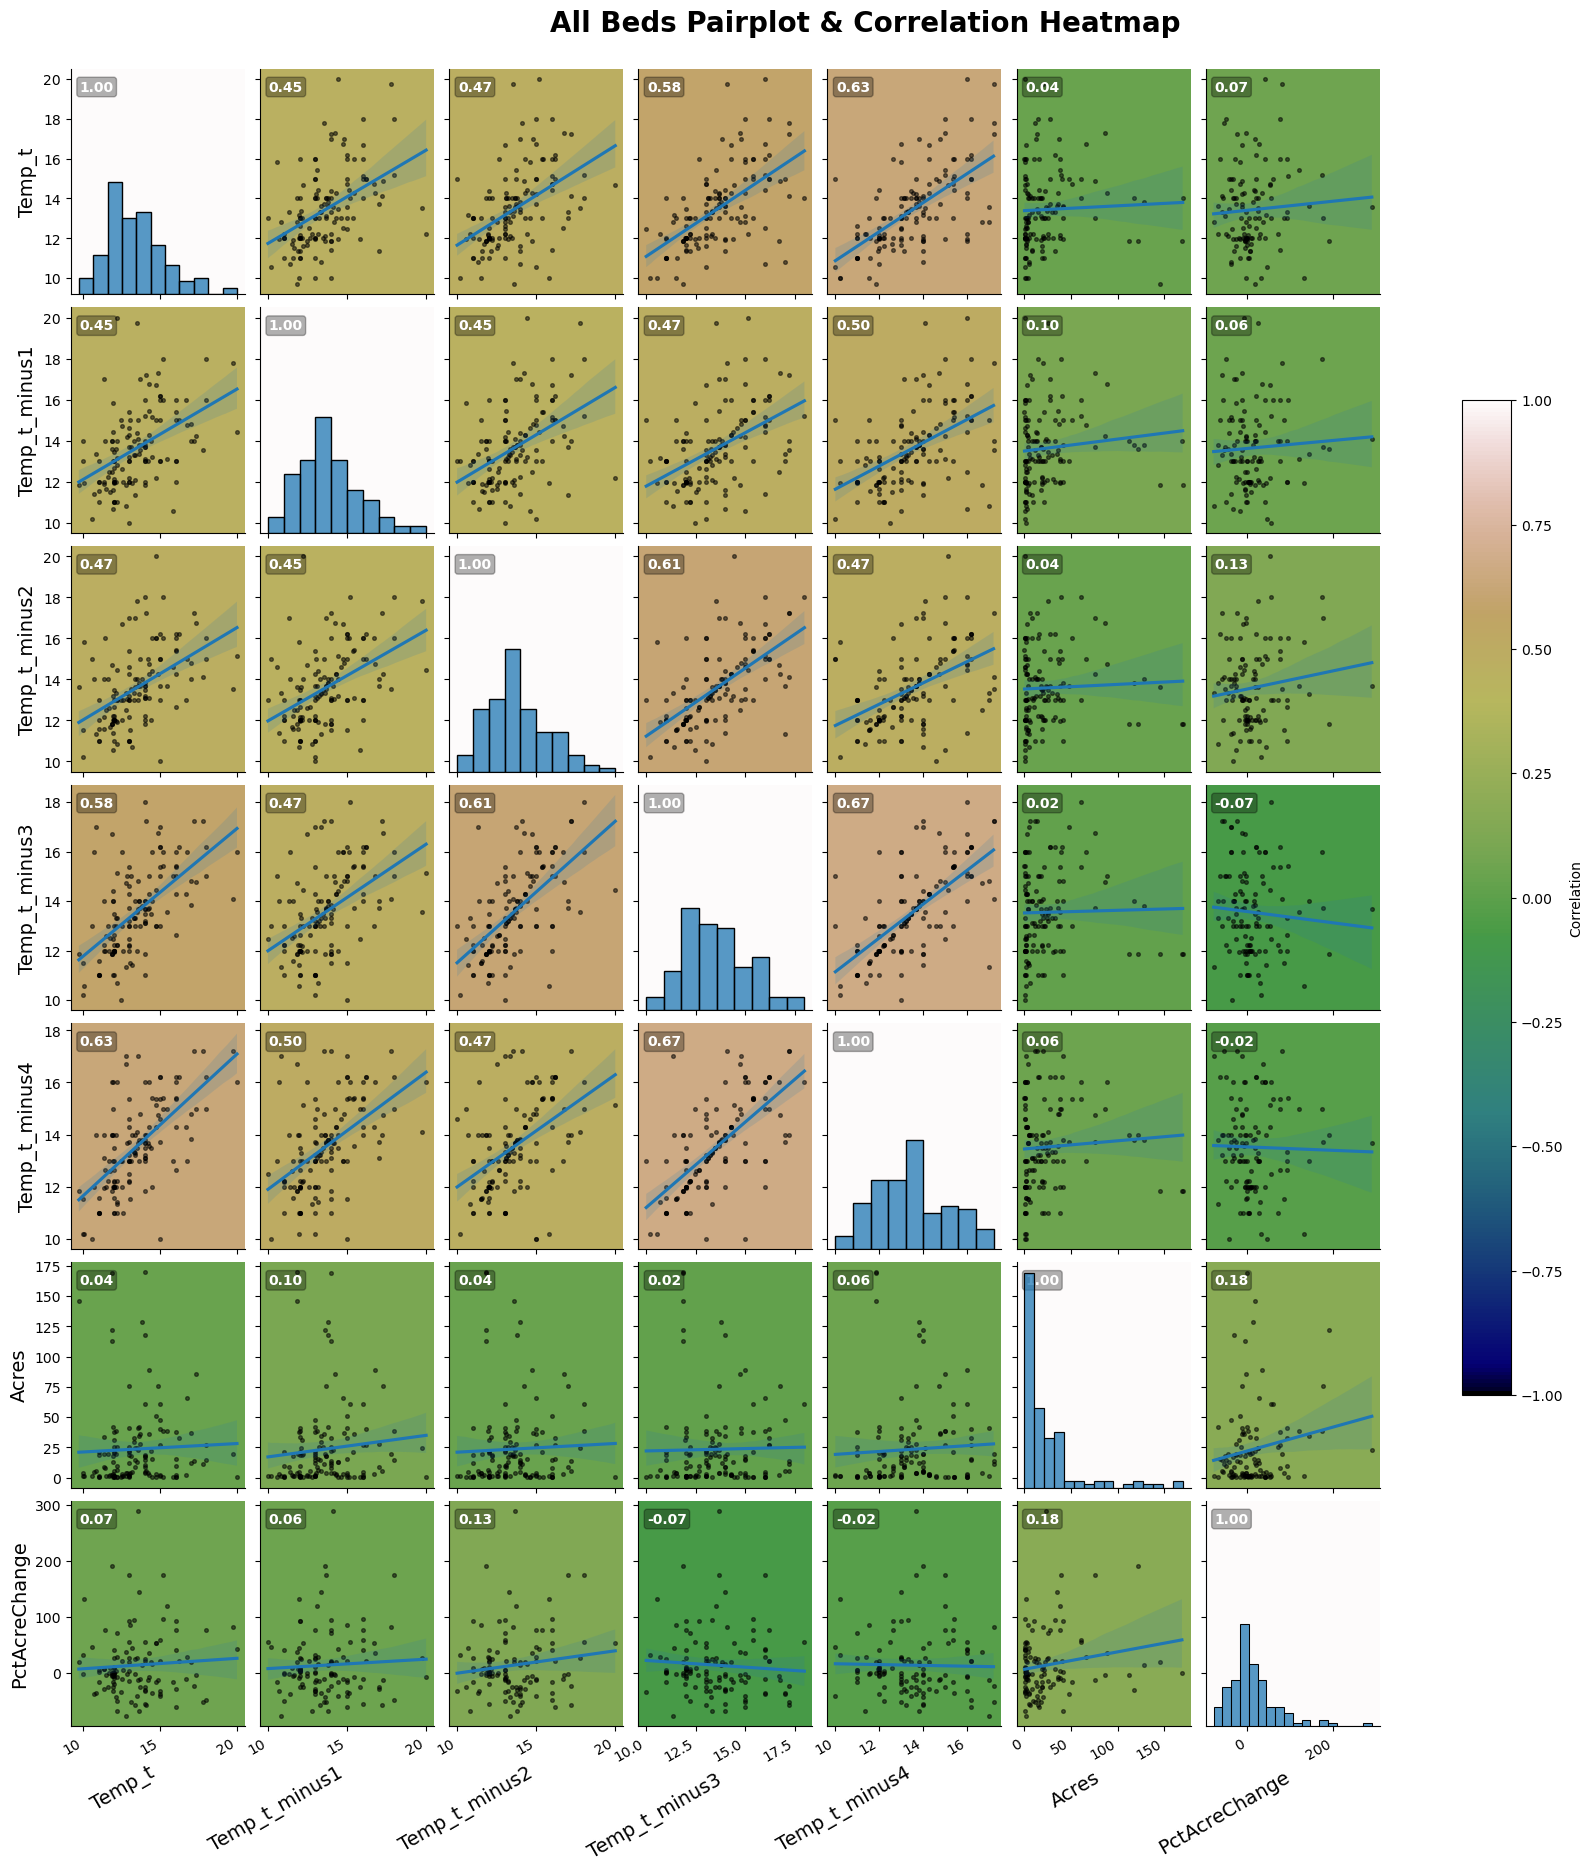

In [16]:
allbed = max_corr_pipeline(allbed)

In [97]:
allbed

,Bed Name,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
0,Aiston Preserve,AISP,31.0,7.0,2018.0,0.117903,16.000,15.415,15.415,15.415,15.415,NaN
1,Aiston Preserve,AISP,1.0,8.0,2019.0,0.167167,16.000,16.000,16.000,16.000,16.000,41.783878
2,Aiston Preserve,AISP,20.0,7.0,2020.0,0.327542,15.150,16.000,16.000,15.415,15.415,95.936898
3,Aiston Preserve,AISP,27.0,7.0,2021.0,0.207529,14.440,15.150,16.000,16.000,15.415,-36.640490
4,Aiston Preserve,AISP,31.0,7.0,2022.0,0.296172,20.000,14.440,15.150,16.000,16.000,42.713633
...,...,...,...,...,...,...,...,...,...,...,...,...
132,Shannon Point West,SHPT-W,18.0,9.0,2020.0,7.790410,11.400,14.000,16.000,12.000,12.649,76.472068
133,Shannon Point West,SHPT-W,19.0,9.0,2021.0,4.860296,10.695,11.400,14.000,16.000,12.000,-37.611814
134,Shannon Point West,SHPT-W,12.0,8.0,2022.0,3.267264,11.945,10.695,11.400,14.000,16.000,-32.776441
135,Shannon Point West,SHPT-W,1.0,9.0,2023.0,4.720687,13.150,11.945,10.695,11.400,14.000,44.484413


In [98]:
 allbed.to_csv(
        f"/Users/carterwebb/Desktop/kelps/data/cleaned_data/corr_dfs/allbed_corrDF.csv",
        index=False
    )